In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Params
img_size = 224
batch_size = 32
num_classes = 10

# Paths
train_dir = r"C:\Users\Dell\Desktop\Music-Classification-MobileNet1\project_data\train_spectrograms"
test_dir = r"C:\Users\Dell\Desktop\Music-Classification-MobileNet1\project_data\test_spectrograms"

# Train/val generators (80/20 split)
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)


print("Train:")
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

print("Val:")
val_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Test generator (no split)
test_datagen = ImageDataGenerator(rescale=1./255)

print("Test:")
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Train:
Found 766 images belonging to 10 classes.
Val:
Found 188 images belonging to 10 classes.
Test:
Found 355 images belonging to 10 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import os


# Model setup
base_model = MobileNetV2(input_shape=(img_size, img_size, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base layers

x = base_model.output
x = GlobalAveragePooling2D()(x)        # Flatten conv output
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',tf.keras.metrics.Precision()])

# Train
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100
)

# Save model
name_model="models/mobilenet_music_classifier11111.keras"
model.save(name_model)

# Test evaluation
print("\nTesting -------------------------------")
results = model.evaluate(test_generator)

# Indeksy: [0] = loss, [1] = accuracy, [2] = precision
test_loss = results[0]
test_acc = results[1]
test_precision = results[2]

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2%}")
print(f"Test Precision: {test_precision:.2%}")

c:\Users\Dell\AppData\Local\pypoetry\Cache\virtualenvs\music-classification-1IWzNP0M-py3.12\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 29s 969ms/step - accuracy: 0.1671 - loss: 2.3669 - precision: 0.0935 - val_accuracy: 0.4202 - val_loss: 1.7663 - val_precision: 1.0000
Epoch 2/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 819ms/step - accuracy: 0.4898 - loss: 1.5859 - precision: 0.9928 - val_accuracy: 0.4255 - val_loss: 1.5304 - val_precision: 0.8500
Epoch 3/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 817ms/step - accuracy: 0.5942 - loss: 1.2742 - precision: 0.9158 - val_accuracy: 0.4468 - val_loss: 1.4375 - val_precision: 0.7705
Epoch 4/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 809ms/step - accuracy: 0.6545 - loss: 1.0948 - precision: 0.9046 - val_accuracy: 0.5000 - val_loss: 1.3593 - val_precision: 0.8143
Epoch 5/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 841ms/step - accuracy: 0.6599 - loss: 1.0044 - precision: 0.8608 - val_accuracy: 0.4681 - val_loss: 1.3959 - val_precision: 0.7125
Epoch 6/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 816ms/step - accuracy: 0.6827 - loss: 0.9429 - precision: 0.8775 - val_accuracy: 0.4734 - val

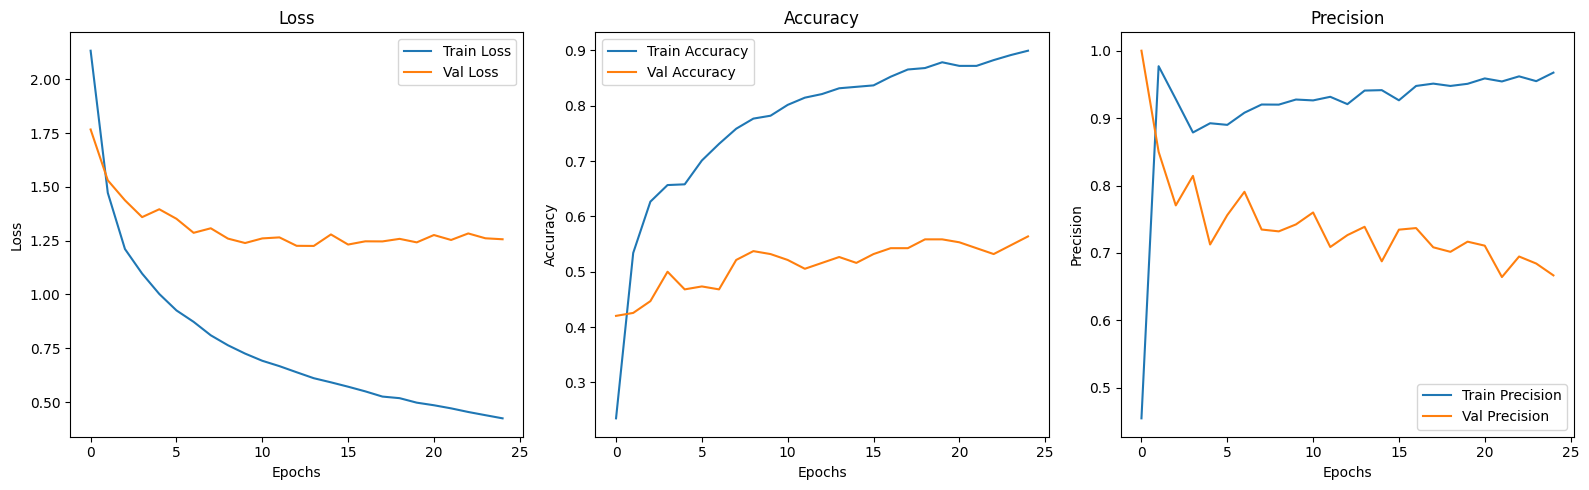

In [3]:
from mobilenet_utils import plot_training_history

plot_training_history(history)

6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 875ms/step


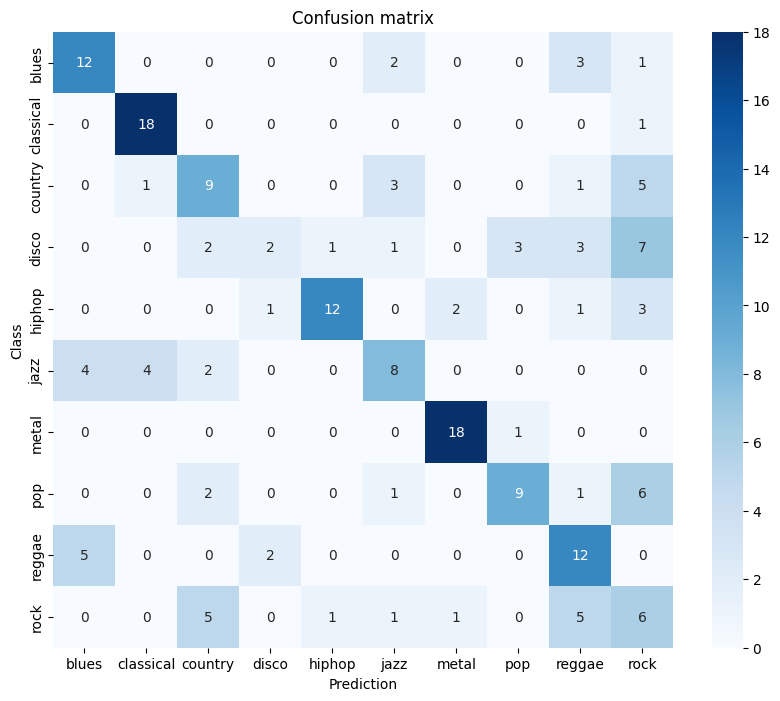

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
import numpy as np

# Generujemy predykcje
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Prawdziwe etykiety
y_true = val_generator.classes

# Nazwy klas
class_labels = list(val_generator.class_indices.keys())

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Prediction")
plt.ylabel("Class")
plt.title("Confusion matrix")
plt.show()

In [ ]:
from gradCAM_utils import gradCAM_img_preprocess, gradCAM_compute, gradCAM_imgHeatmapOverlay
import cv2
import os


#model.summary()

data_folder = "data/spectograms"
gradcam_path = 'data/gradcam'

# Iterate through each genre folder and collect file names
for genre in os.listdir(data_folder):
    genre_folder = os.path.join(data_folder, genre)
    if os.path.isdir(genre_folder):
        for file_name in os.listdir(genre_folder):
            print(file_name)
            img = os.path.join(genre_folder, file_name)
            img_array = gradCAM_img_preprocess(img)
            preds = model.predict(img_array)
            class_index = np.argmax(preds[0])
            heatmap = gradCAM_compute(model, img_array, class_index)
            output_img = gradCAM_imgHeatmapOverlay(img, heatmap)
            genre_folder_grad = os.path.join(gradcam_path, genre)
            output_path = os.path.join(genre_folder_grad, f"{file_name}_gradCAM.jpg")
            cv2.imwrite(output_path, output_img)
            del output_img
            







blues.00000.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
blues.00001.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
blues.00002.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
blues.00003.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
blues.00004.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
blues.00005.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
blues.00006.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
blues.00007.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
blues.00008.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
blues.00009.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
blues.00010.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
blues.00011.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
blues.00012.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
blues.00013.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
blues.00014.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
blues.00015.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
blues.00016.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
blues.00017.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
blues.00018.png
1/1 ━━━━━━━━

Traceback (most recent call last):
  File "c:\Users\Dell\AppData\Local\pypoetry\Cache\virtualenvs\music-classification-1IWzNP0M-py3.12\Lib\site-packages\IPython\core\interactiveshell.py", line 2176, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dell\AppData\Local\pypoetry\Cache\virtualenvs\music-classification-1IWzNP0M-py3.12\Lib\site-packages\IPython\core\ultratb.py", line 1182, in structured_traceback
    return FormattedTB.structured_traceback(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dell\AppData\Local\pypoetry\Cache\virtualenvs\music-classification-1IWzNP0M-py3.12\Lib\site-packages\IPython\core\ultratb.py", line 1053, in structured_traceback
    return VerboseTB.structured_traceback(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dell\AppData\Local\pypoetry\Cache\virtualenvs\music-classification-1IWzNP0M-py3.12\Lib\site-packages\IPython\core\ultratb.py", line